In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation

In [242]:
# Setting the number of spacial and time increments
Nx = 1000
Nt = 100


# Setting the start time and end time
t_0 = 0
t_T = 100


# Setting the start and end of the rod
X_Nx = 1
X_0 = 0


# Finding the step sizes for space and time
dx = (X_Nx - X_0)/Nx
dt = (t_T - t_0)/Nt


# Setting the proportion of the length which will be sword (always centred)
# for eg right now its the middle third
sword_prop = 1/3
sword_temp = 1000 # Initial temp of the sword
water_temp = 50 # Initial temp of the water


# Finding the indexes for the edges of the sword, x1 and x2, assuming its placed centrally
# ...i.e, the number of increments along the sword edges are.
X_1_index = int(((X_Nx - X_0) - sword_prop)/2 * Nx)
X_2_index = int((1 -((X_Nx - X_0) - sword_prop)/2) * Nx)


Nx1 = X_1_index
Nx2 = X_2_index - X_1_index
Nx3 = Nx - X_2_index


# The diffusivity constant - we can make this a step function of x and make a "diffusivity array"..
# ...similar to how ive defined the initial condition below
D_sword = 10
D_water = 0.14

In [237]:
# Defining the sword temperature as a function
# ...this means we can vary the heat distribution across the swords width later if we want
# ...right now its just uniformly "sword_temp"
def sword_func(sword_temp, sword):
    
    return sword*0 + sword_temp


# Defining the initial condition
def Ics(X_1_index, X_2_index, sword_prop, sword_temp, water_temp):
    
    # Making an array of zeros of the right size and updating the area the sword inhabits using our sword temp function
    Ics = np.zeros(Nx)
    Ics += water_temp
    Ics[X_1_index : X_2_index] = sword_func(sword_temp, Ics[X_1_index : X_2_index]) 
    
    return Ics

In [238]:
U = np.zeros([Nx, Nt])

U[:, 0] = Ics(X_1_index, X_2_index, sword_prop, sword_temp, water_temp)

In [243]:
# This bit is backward euler with neumann (no-flux) conditions, from the last slide of the week2 live lecture

# Pre-defining an array of Diffusion values
def diffus_array(D_water, D_sword, X_1_index, X_2_index, dt, dx):
    
    D = np.zeros(Nx)
    
    D += D_water
    
    D[X_1_index : X_2_index] = D_sword
    
    return D

D = diffus_array(D_water, D_sword, X_1_index, X_2_index, dt, dx)

# Setting the value of our constant C
C = dt/(2*dx**2)

# To form our A, we make an empty array first
A = np.zeros([Nx, Nx])

# We define the middle of A, row by row
for m in range(2, Nx-2):
    
    A[m, m-2:m+3] = [-C*D[m-1], 0, C*(D[m-1] + D[m+1] + 2*(dx**2)), 0, -C*D[m+1]]
    

# ...then defining the first and last rows, according to our boundary conditions
# we are assuming U_-2 = U_2 (ask ben next week)

A[0, 0:3] = [2*C*D[1] + 2*C*(dx**2), 0, -2*C*D[1]]
A[1, 1:4] = [C*D[2] + 2*C*(dx**2), 0, -C*D[2]]
A[-2, -4:-1] = [-C*D[-3], 0, C*D[-3] + 2*C*(dx**2)]
A[-1, -3:] = [-2*C*D[-2], 0, 2*C*D[-2] + 2*C*(dx**2)]


#------------------------------------------------------------------------------------#
### THE ABOVE CODE DOES NOT WORK, THERE IS AN ERROR SOMEWHERE...
# ... regardless of the size of dx, it runs perfectly when dt = 1, however when dt < 1 it collapses...
#... and when dt > 1 it blows up.
# This suggests to me our formulation went wrong somewhere, specifically an issue with a dt term.
### POINTS FOR FINDING THE ERROR
#------------------------------------------------------------------------------------#


# Finding the inverse of A
Ainv = linalg.inv(A)

# ...and implementing backward euler
for n in range(Nt - 1):
    
    U[:, n+1] = np.matmul(Ainv, U[:, n])

# We end up with all our discretised data in the matrix U
### IMPORTANT --- it's coded so each ROW of U represents the temperature across the rod at a fixed time.

In [244]:
# Defining Nx linearly spaced points and Nt linearly spaced times
X = np.linspace(X_0, X_Nx, Nx)
T = np.linspace(t_0, t_T, Nt)


# Finding the area under the curve at each timestep:
# We set up a vector
Curve_Area = np.ones(Nt)

# And use the trapezium method to get the area under the curve for each time
for n in range(Nt):

    Curve_Area[n] = np.trapz(U[:, n], X)

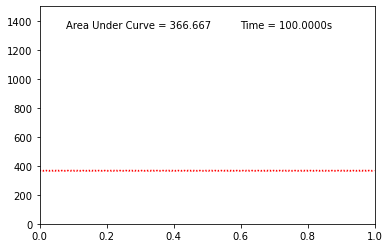

In [245]:
# We make an animation of how to temperature changes throughout the system with time

# Setting up animation plots
fig, ax = plt.subplots()
ax.axis([X_0, X_Nx, 0, max(sword_temp, water_temp)*1.5]) # Setting axis limits -- the xlims are the ends of the rod

# Making a template to update with values for our time and area-under-the-curve counters
area_template = 'Area Under Curve = %.3f'
time_template = 'Time = %.4fs'

# Setting the initial text strings, specifying placement in the graph
area_text= ax.text(0.08, 0.9, '', transform = ax.transAxes)
time_text = ax.text(0.6, 0.9, '', transform = ax.transAxes)

# We define a function which updates our plot each timestep
def animate(n):
    
    l.set_data(X, U[:, n]) # Updates the temperature vector each timestep

    # Updates our area amd time captions each timestep
    time_text.set_text(time_template % T[n]) 
    area_text.set_text(area_template % Curve_Area[n])
    
    return l, time_text, area_text

# Plotting the new data (in red dots)
l, = ax.plot([],[],':r')

# Creating the animation
ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt)

# and displaying it
from IPython.display import HTML
HTML(ani2.to_jshtml())